In [1]:
# %pip install pandas
# %pip install shap
# %pip install sklearn
# %pip install xgboost
# %pip install nltk
# %pip install gensim
# %pip install alibi
# %pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

from alibi.explainers import Counterfactual

import shap
shap.initjs()

/Users/miri/miniconda3/envs/conda_venv_rl/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# SHAP

In [2]:
book_data = pd.read_csv("./data/books.csv", sep=";")

#assign target variable and features
y = book_data['Bewertung']
X = book_data.drop('Bewertung', axis=1)
X = X.drop('Titel', axis=1)

authors = X.Autor.astype("category").cat.categories
publisher = X.Verlag.astype("category").cat.categories
genre = X.Genre.astype("category").cat.categories
thema = X.Thema.astype("category").cat.categories

#convert data to categoricals
X.Autor = X.Autor.astype("category").cat.codes
# calculate age of book
X['Alter in Jahren'] = 2022 - X.Jahr
X = X.drop('Jahr', axis=1)
X.Genre = X.Genre.astype("category").cat.codes
X.Thema = X.Thema.astype("category").cat.codes
X.Verlag = X.Verlag.astype("category").cat.codes

X.head(20)

Autor  Verlag  Seitenanzahl  Genre  Thema  Alter in Jahren
0       8       2           335      0      0               25
1       8       2           304      0      0                5
2      15       8           414      0      0               13
3      10      12           368      0      2                2
4      18       9           528      2      1                7
5      11      15          1120      1      3               86
6       2      10           624      2      1                6
7      14       1           800      2      6                0
8       9       6           549      1      5              129
9      16       3           728      1      1              121
10      6       3           256      2      1                5
11      3      13           383      2      1               13
12     13       5           864      0      2               35
13      4       5           800      0      0               56
14      7       7           491      0      0               56
15     17       4           654      0      2               40
16      1       0           605      0      4               22
17     12      14           428      0      0               43
18      0       5           448      0      0                0
19      5      11           798      0      0               26

In [3]:
authors, publisher, genre, thema

(Index(['Bernhard Hennen', 'Dan Brown', 'Daniel Kahneman',
        'Eckardt von Hirschhausen', 'Frank Herbert', 'George R.R. Martin',
        'Gerald Hüther', 'J.R.R. Tolkien', 'Joanne K. Rowling', 'Karl May',
        'Laura Baldini', 'Margaret Mitchel', 'Michael Ende', 'Noah Gordon',
        'Ralph Bollmann', 'Suzan Collings', 'Thomas Mann', 'Umberto Eco',
        'Yuval Noah Harari'],
       dtype='object'),
 Index(['Bastei Luebbe', 'C.H.Beck', 'Carlsen', 'Fischer', 'Hanser', 'Heyne',
        'Karl-May-Verlag', 'Klett', 'Oetinger', 'Pantheon', 'Penguin',
        'Penguin Random House', 'Piper', 'Rowohlt', 'Thienemann',
        'Ullistein Taschenbuch Verlag'],
       dtype='object'),
 Index(['Fiktive Romane', 'Realistische Erzählung', 'Sachbuch'], dtype='object'),
 Index(['Fantasy', 'Gesellschaft', 'Historisch', 'Romanze', 'Thriller',
        'Western', 'biography'],
       dtype='object'))

In [4]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [5]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap_values.data.shape

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(20, 6)

In [6]:
#change categorical numbers back to names
named_data = []
for data_array in shap_values.data:
    categories = np.array([authors[data_array[0]],
                publisher[data_array[1]],data_array[2],
                genre[data_array[3]],
                thema[data_array[4]], data_array[5]])
    named_data.append(categories)

shap_values.data = np.array(named_data)

In [7]:
for index in range(0,len(shap_values)):
    shap.plots.waterfall(shap_values[index], show=False)
    plt.savefig(F'../public/waterfall{index}.svg', dpi=200, bbox_inches = "tight")
    plt.clf()

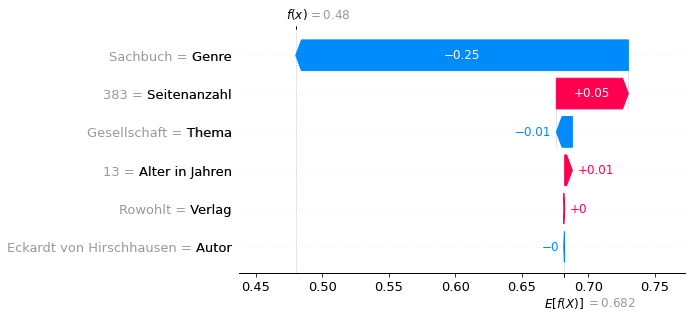

In [8]:
shap.plots.waterfall(shap_values[11])

# Counterfactuals

In [9]:
import dice_ml
from dice_ml import Dice

from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import pandas as pd

In [10]:
book_data = pd.read_csv("./data/books.csv", sep=";")

#assign target variable and features
y = book_data['Bewertung']
X = book_data.drop('Bewertung', axis=1)
X = X.drop('Titel', axis=1)

X['Alter in Jahren'] = 2022 - X.Jahr
X = X.drop('Jahr', axis=1)

X.head(20)



Autor                        Verlag  Seitenanzahl  \
0          Joanne K. Rowling                       Carlsen           335   
1          Joanne K. Rowling                       Carlsen           304   
2             Suzan Collings                      Oetinger           414   
3              Laura Baldini                         Piper           368   
4          Yuval Noah Harari                      Pantheon           528   
5           Margaret Mitchel  Ullistein Taschenbuch Verlag          1120   
6            Daniel Kahneman                       Penguin           624   
7             Ralph Bollmann                      C.H.Beck           800   
8                   Karl May               Karl-May-Verlag           549   
9                Thomas Mann                       Fischer           728   
10             Gerald Hüther                       Fischer           256   
11  Eckardt von Hirschhausen                       Rowohlt           383   
12               Noah Gordon                         Heyne           864   
13             Frank Herbert                         Heyne           800   
14            J.R.R. Tolkien                         Klett           491   
15               Umberto Eco                        Hanser           654   
16                 Dan Brown                 Bastei Luebbe           605   
17              Michael Ende                    Thienemann           428   
18           Bernhard Hennen                         Heyne           448   
19        George R.R. Martin          Penguin Random House           798   

                     Genre         Thema  Alter in Jahren  
0           Fiktive Romane       Fantasy               25  
1           Fiktive Romane       Fantasy                5  
2           Fiktive Romane       Fantasy               13  
3           Fiktive Romane    Historisch                2  
4                 Sachbuch  Gesellschaft                7  
5   Realistische Erzählung       Romanze               86  
6                 Sachbuch  Gesellschaft                6  
7                 Sachbuch     biography                0  
8   Realistische Erzählung       Western              129  
9   Realistische Erzählung  Gesellschaft              121  
10                Sachbuch  Gesellschaft                5  
11                Sachbuch  Gesellschaft               13  
12          Fiktive Romane    Historisch               35  
13          Fiktive Romane       Fantasy               56  
14          Fiktive Romane       Fantasy               56  
15          Fiktive Romane    Historisch               40  
16          Fiktive Romane      Thriller               22  
17          Fiktive Romane       Fantasy               43  
18          Fiktive Romane       Fantasy                0  
19          Fiktive Romane       Fantasy               26

In [11]:
book_df = X.copy()
book_df['Bewertung'] = y
book_df

Autor                        Verlag  Seitenanzahl  \
0          Joanne K. Rowling                       Carlsen           335   
1          Joanne K. Rowling                       Carlsen           304   
2             Suzan Collings                      Oetinger           414   
3              Laura Baldini                         Piper           368   
4          Yuval Noah Harari                      Pantheon           528   
5           Margaret Mitchel  Ullistein Taschenbuch Verlag          1120   
6            Daniel Kahneman                       Penguin           624   
7             Ralph Bollmann                      C.H.Beck           800   
8                   Karl May               Karl-May-Verlag           549   
9                Thomas Mann                       Fischer           728   
10             Gerald Hüther                       Fischer           256   
11  Eckardt von Hirschhausen                       Rowohlt           383   
12               Noah Gordon                         Heyne           864   
13             Frank Herbert                         Heyne           800   
14            J.R.R. Tolkien                         Klett           491   
15               Umberto Eco                        Hanser           654   
16                 Dan Brown                 Bastei Luebbe           605   
17              Michael Ende                    Thienemann           428   
18           Bernhard Hennen                         Heyne           448   
19        George R.R. Martin          Penguin Random House           798   

                     Genre         Thema  Alter in Jahren  Bewertung  
0           Fiktive Romane       Fantasy               25       0.92  
1           Fiktive Romane       Fantasy                5       0.95  
2           Fiktive Romane       Fantasy               13       0.95  
3           Fiktive Romane    Historisch                2       0.85  
4                 Sachbuch  Gesellschaft                7       0.40  
5   Realistische Erzählung       Romanze               86       0.28  
6                 Sachbuch  Gesellschaft                6       0.38  
7                 Sachbuch     biography                0       0.42  
8   Realistische Erzählung       Western              129       0.42  
9   Realistische Erzählung  Gesellschaft              121       0.39  
10                Sachbuch  Gesellschaft                5       0.49  
11                Sachbuch  Gesellschaft               13       0.48  
12          Fiktive Romane    Historisch               35       0.70  
13          Fiktive Romane       Fantasy               56       0.85  
14          Fiktive Romane       Fantasy               56       0.87  
15          Fiktive Romane    Historisch               40       0.80  
16          Fiktive Romane      Thriller               22       0.80  
17          Fiktive Romane       Fantasy               43       0.87  
18          Fiktive Romane       Fantasy                0       0.95  
19          Fiktive Romane       Fantasy               26       0.87

In [12]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

continous_features_books = book_df[['Seitenanzahl', 'Alter in Jahren']].columns.tolist()
categorical_features_books = X.columns.difference(continous_features_books)

transformations_books = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continous_features_books),
        ('cat', categorical_transformer, categorical_features_books)])

In [13]:
regr_books = Pipeline(steps=[('preprocessor', transformations_books),
                               ('regressor', RandomForestRegressor())])
model_books = regr_books.fit(X,y)

In [14]:
d_books = dice_ml.Data(dataframe=book_df, continuous_features=continous_features_books, outcome_name='Bewertung')
# We provide the type of model as a parameter (model_type)
m_books = dice_ml.Model(model=model_books, backend="sklearn", model_type='regressor')

In [15]:
exp_genetic_books = Dice(d_books, m_books, method="genetic")

In [16]:
query_instances_books = X[5:10]
genetic_books = exp_genetic_books.generate_counterfactuals(query_instances_books,
                                                               total_CFs=2,
                                                               desired_range=[0.8, 0.9])
genetic_books.visualize_as_dataframe()

100%|██████████| 5/5 [00:18<00:00,  3.78s/it]

Query instance (original outcome : 0)


Autor                        Verlag  Seitenanzahl  \
0  Margaret Mitchel  Ullistein Taschenbuch Verlag          1120   

                    Genre    Thema  Alter in Jahren  Bewertung  
0  Realistische Erzählung  Romanze               86      0.331


Diverse Counterfactual set (new outcome: [0.8, 0.9])


Autor           Verlag  Seitenanzahl           Genre  \
0  Bernhard Hennen  Karl-May-Verlag         798.0  Fiktive Romane   
0  Bernhard Hennen            Heyne         798.0  Fiktive Romane   

          Thema  Alter in Jahren  Bewertung  
0  Gesellschaft             79.0     0.8038  
0       Fantasy             79.0     0.8604

Query instance (original outcome : 0)


Autor   Verlag  Seitenanzahl     Genre         Thema  \
0  Daniel Kahneman  Penguin           624  Sachbuch  Gesellschaft   

   Alter in Jahren  Bewertung  
0                6     0.3907


Diverse Counterfactual set (new outcome: [0.8, 0.9])


Autor           Verlag  Seitenanzahl           Genre     Thema  \
0  Daniel Kahneman  Karl-May-Verlag         393.0  Fiktive Romane   Western   
0  Daniel Kahneman          Fischer         393.0  Fiktive Romane  Thriller   

   Alter in Jahren  Bewertung  
0              2.0     0.8498  
0              2.0     0.8486

Query instance (original outcome : 0)


Autor    Verlag  Seitenanzahl     Genre      Thema  \
0  Ralph Bollmann  C.H.Beck           800  Sachbuch  biography   

   Alter in Jahren  Bewertung  
0                0     0.4108


Diverse Counterfactual set (new outcome: [0.8, 0.9])


Autor    Verlag  Seitenanzahl           Genre      Thema  \
0  Ralph Bollmann  C.H.Beck         256.0  Fiktive Romane  biography   

   Alter in Jahren  Bewertung  
0              0.0     0.8556

Query instance (original outcome : 0)


Autor           Verlag  Seitenanzahl                   Genre    Thema  \
0  Karl May  Karl-May-Verlag           549  Realistische Erzählung  Western   

   Alter in Jahren  Bewertung  
0              129     0.4189


Diverse Counterfactual set (new outcome: [0.8, 0.9])


Autor    Verlag  Seitenanzahl           Genre  \
0  Eckardt von Hirschhausen  C.H.Beck         524.0  Fiktive Romane   
0            J.R.R. Tolkien     Klett         491.0  Fiktive Romane   

          Thema  Alter in Jahren  Bewertung  
0  Gesellschaft            112.0     0.8220  
0       Fantasy            112.0     0.8708

Query instance (original outcome : 0)


Autor   Verlag  Seitenanzahl                   Genre         Thema  \
0  Thomas Mann  Fischer           728  Realistische Erzählung  Gesellschaft   

   Alter in Jahren  Bewertung  
0              121     0.4061


Diverse Counterfactual set (new outcome: [0.8, 0.9])


Autor         Verlag  Seitenanzahl           Genre      Thema  \
0     Thomas Mann        Penguin         895.0  Fiktive Romane    Fantasy   
0  Suzan Collings  Bastei Luebbe         675.0  Fiktive Romane  biography   

   Alter in Jahren  Bewertung  
0            109.0     0.8289  
0            120.0     0.8179

In [17]:
query_instances_books = X[10:15]
genetic_books = exp_genetic_books.generate_counterfactuals(query_instances_books,
                                                               total_CFs=2,
                                                               desired_range=[0.9, 1.0])
genetic_books.visualize_as_dataframe()

100%|██████████| 5/5 [03:44<00:00, 44.81s/it]

Query instance (original outcome : 0)


Autor   Verlag  Seitenanzahl     Genre         Thema  \
0  Gerald Hüther  Fischer           256  Sachbuch  Gesellschaft   

   Alter in Jahren  Bewertung  
0                5     0.4713


Diverse Counterfactual set (new outcome: [0.9, 1.0])


Autor   Verlag  Seitenanzahl           Genre    Thema  \
0  Joanne K. Rowling  Carlsen         304.0  Fiktive Romane  Fantasy   
0    Bernhard Hennen    Heyne         256.0  Fiktive Romane  Fantasy   

   Alter in Jahren  Bewertung  
0              5.0     0.9380  
0              3.0     0.9327

Query instance (original outcome : 0)


Autor   Verlag  Seitenanzahl     Genre         Thema  \
0  Eckardt von Hirschhausen  Rowohlt           383  Sachbuch  Gesellschaft   

   Alter in Jahren  Bewertung  
0               13     0.4593


Diverse Counterfactual set (new outcome: [0.9, 1.0])


Autor      Verlag  Seitenanzahl           Genre  \
0            Suzan Collings    Oetinger         414.0  Fiktive Romane   
0  Eckardt von Hirschhausen  Thienemann         367.0  Fiktive Romane   

     Thema  Alter in Jahren  Bewertung  
0  Fantasy             13.0     0.9329  
0  Fantasy              8.0     0.9234

Query instance (original outcome : 1)


Autor Verlag  Seitenanzahl           Genre       Thema  \
0  Noah Gordon  Heyne           864  Fiktive Romane  Historisch   

   Alter in Jahren  Bewertung  
0               35     0.7386


Diverse Counterfactual set (new outcome: [0.9, 1.0])


Autor Verlag  Seitenanzahl           Genre    Thema  \
0  Eckardt von Hirschhausen  Heyne         507.0  Fiktive Romane  Fantasy   
0            J.R.R. Tolkien  Heyne         256.0  Fiktive Romane  Fantasy   

   Alter in Jahren  Bewertung  
0             12.0     0.9076  
0              8.0     0.9295

Query instance (original outcome : 1)


Autor Verlag  Seitenanzahl           Genre    Thema  \
0  Frank Herbert  Heyne           800  Fiktive Romane  Fantasy   

   Alter in Jahren  Bewertung  
0               56     0.8526


Diverse Counterfactual set (new outcome: [0.9, 1.0])


Autor      Verlag  Seitenanzahl           Genre    Thema  \
0  Frank Herbert  Thienemann         432.0  Fiktive Romane  Fantasy   
0  Frank Herbert  Thienemann         510.0  Fiktive Romane  Fantasy   

   Alter in Jahren  Bewertung  
0             19.0     0.9093  
0              4.0     0.9064

Query instance (original outcome : 1)


Autor Verlag  Seitenanzahl           Genre    Thema  \
0  J.R.R. Tolkien  Klett           491  Fiktive Romane  Fantasy   

   Alter in Jahren  Bewertung  
0               56     0.8708


Diverse Counterfactual set (new outcome: [0.9, 1.0])


Autor   Verlag  Seitenanzahl           Genre    Thema  \
0  J.R.R. Tolkien    Klett         565.0  Fiktive Romane  Fantasy   
0  J.R.R. Tolkien  Rowohlt         413.0  Fiktive Romane  Fantasy   

   Alter in Jahren  Bewertung  
0              1.0     0.9003  
0             12.0     0.9253